In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import catboost as cb
import xgboost as xgb
import lightgbm as lgbm
import sys

from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, GradientBoostingRegressor, StackingClassifier, StackingRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

sys.path.append("..")

from models.decisiontrees import MyDecisionTreeClassifier

# Подготовка данных

In [2]:
pd.set_option('display.max_columns', 30)

In [3]:
data_class = pd.read_csv('../data/rainAUS_prepared.csv')
data_class

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,ord__Location,ord__WindDir9am,ord__WindGustDir,ord__WindDir3pm,ord__RainToday,RainTomorrow
0,12,13.4,22.9,0.6,4.0,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,2.0,13.0,13.0,14.0,0.0,0
1,12,7.4,25.1,0.0,4.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,2.0,6.0,14.0,15.0,0.0,0
2,12,12.9,25.7,0.0,4.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,2.0,13.0,15.0,15.0,0.0,0
3,12,9.2,28.0,0.0,4.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,2.0,9.0,4.0,0.0,0.0,0
4,12,17.5,32.3,1.0,4.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2.0,1.0,13.0,7.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,6,3.5,21.8,0.0,4.0,31.0,15.0,13.0,59.0,27.0,1024.7,1021.2,7.0,7.0,9.4,20.9,41.0,2.0,0.0,0.0,0.0,0
142189,6,2.8,23.4,0.0,4.0,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,7.0,7.0,10.1,22.4,41.0,9.0,0.0,1.0,0.0,0
142190,6,3.6,25.3,0.0,4.0,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,7.0,10.9,24.5,41.0,9.0,6.0,3.0,0.0,0
142191,6,5.4,26.9,0.0,4.0,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,7.0,7.0,12.5,26.1,41.0,9.0,3.0,14.0,0.0,0


In [4]:
data_reg_white = pd.read_csv('../data/winequality-white.csv', sep = ';')
data_reg_red = pd.read_csv('../data/winequality-red.csv', sep = ';')

In [5]:
data_reg_white['color'] = 0
data_reg_red['color'] = 1

In [6]:
data_reg = pd.concat([data_reg_white, data_reg_red], axis = 0)
data_reg.reset_index()
data_reg

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


# Разделение выборок

In [7]:
y_cl = data_class['RainTomorrow']
X_cl = data_class.drop(['RainTomorrow'], axis=1)

In [8]:
nm = NearMiss()
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, test_size=0.2)
X_train_cl, y_train_cl = nm.fit_resample(X_train_cl, y_train_cl.ravel())

In [9]:
y_reg = data_reg['quality']
X_reg = data_reg.drop(['quality'], axis=1)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, stratify = y_reg)

# Построение деревьев

In [10]:
def T(tr, task):
    if task == 'cl':
        fig = plt.figure(figsize=(25,20))
        k = tree.plot_tree(tr, feature_names=X_cl.columns.to_list(), class_names=['Rainy', 'NotRainy'], filled=True)
    elif task == 'rg':
        fig = plt.figure(figsize=(25,20))
        k = tree.plot_tree(tr, feature_names=X_reg.columns.to_list(), filled=True)

In [11]:
def show_class(y_test, predict):
    print(classification_report(y_test, predict))    

def show_roc(X_test, y_test, model):
    %matplotlib inline
    
    y_scores = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    
    fig = plt.figure(figsize=(6, 6))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print(f'AUC: {roc_auc_score(y_test, y_scores[:,1])}')

In [12]:
def show_reg(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    
    return {'MAE' : MAE, 'MSE' : MSE, 'MAPE': MAPE, 'R2' : R2}

## DecisionTreeClassifier

In [19]:
parameters_c = {
    'max_depth': np.arange(3, 5, 1), 'min_samples_split': np.arange(2, 10, 1), 
    'min_samples_leaf': np.arange(1, 5, 1), 'criterion': ['gini', 'entropy', 'log_loss']
}

clf = GridSearchCV(DecisionTreeClassifier(), parameters_c).fit(X_train_cl, y_train_cl)
print(clf.best_params_)
clf = clf.best_estimator_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


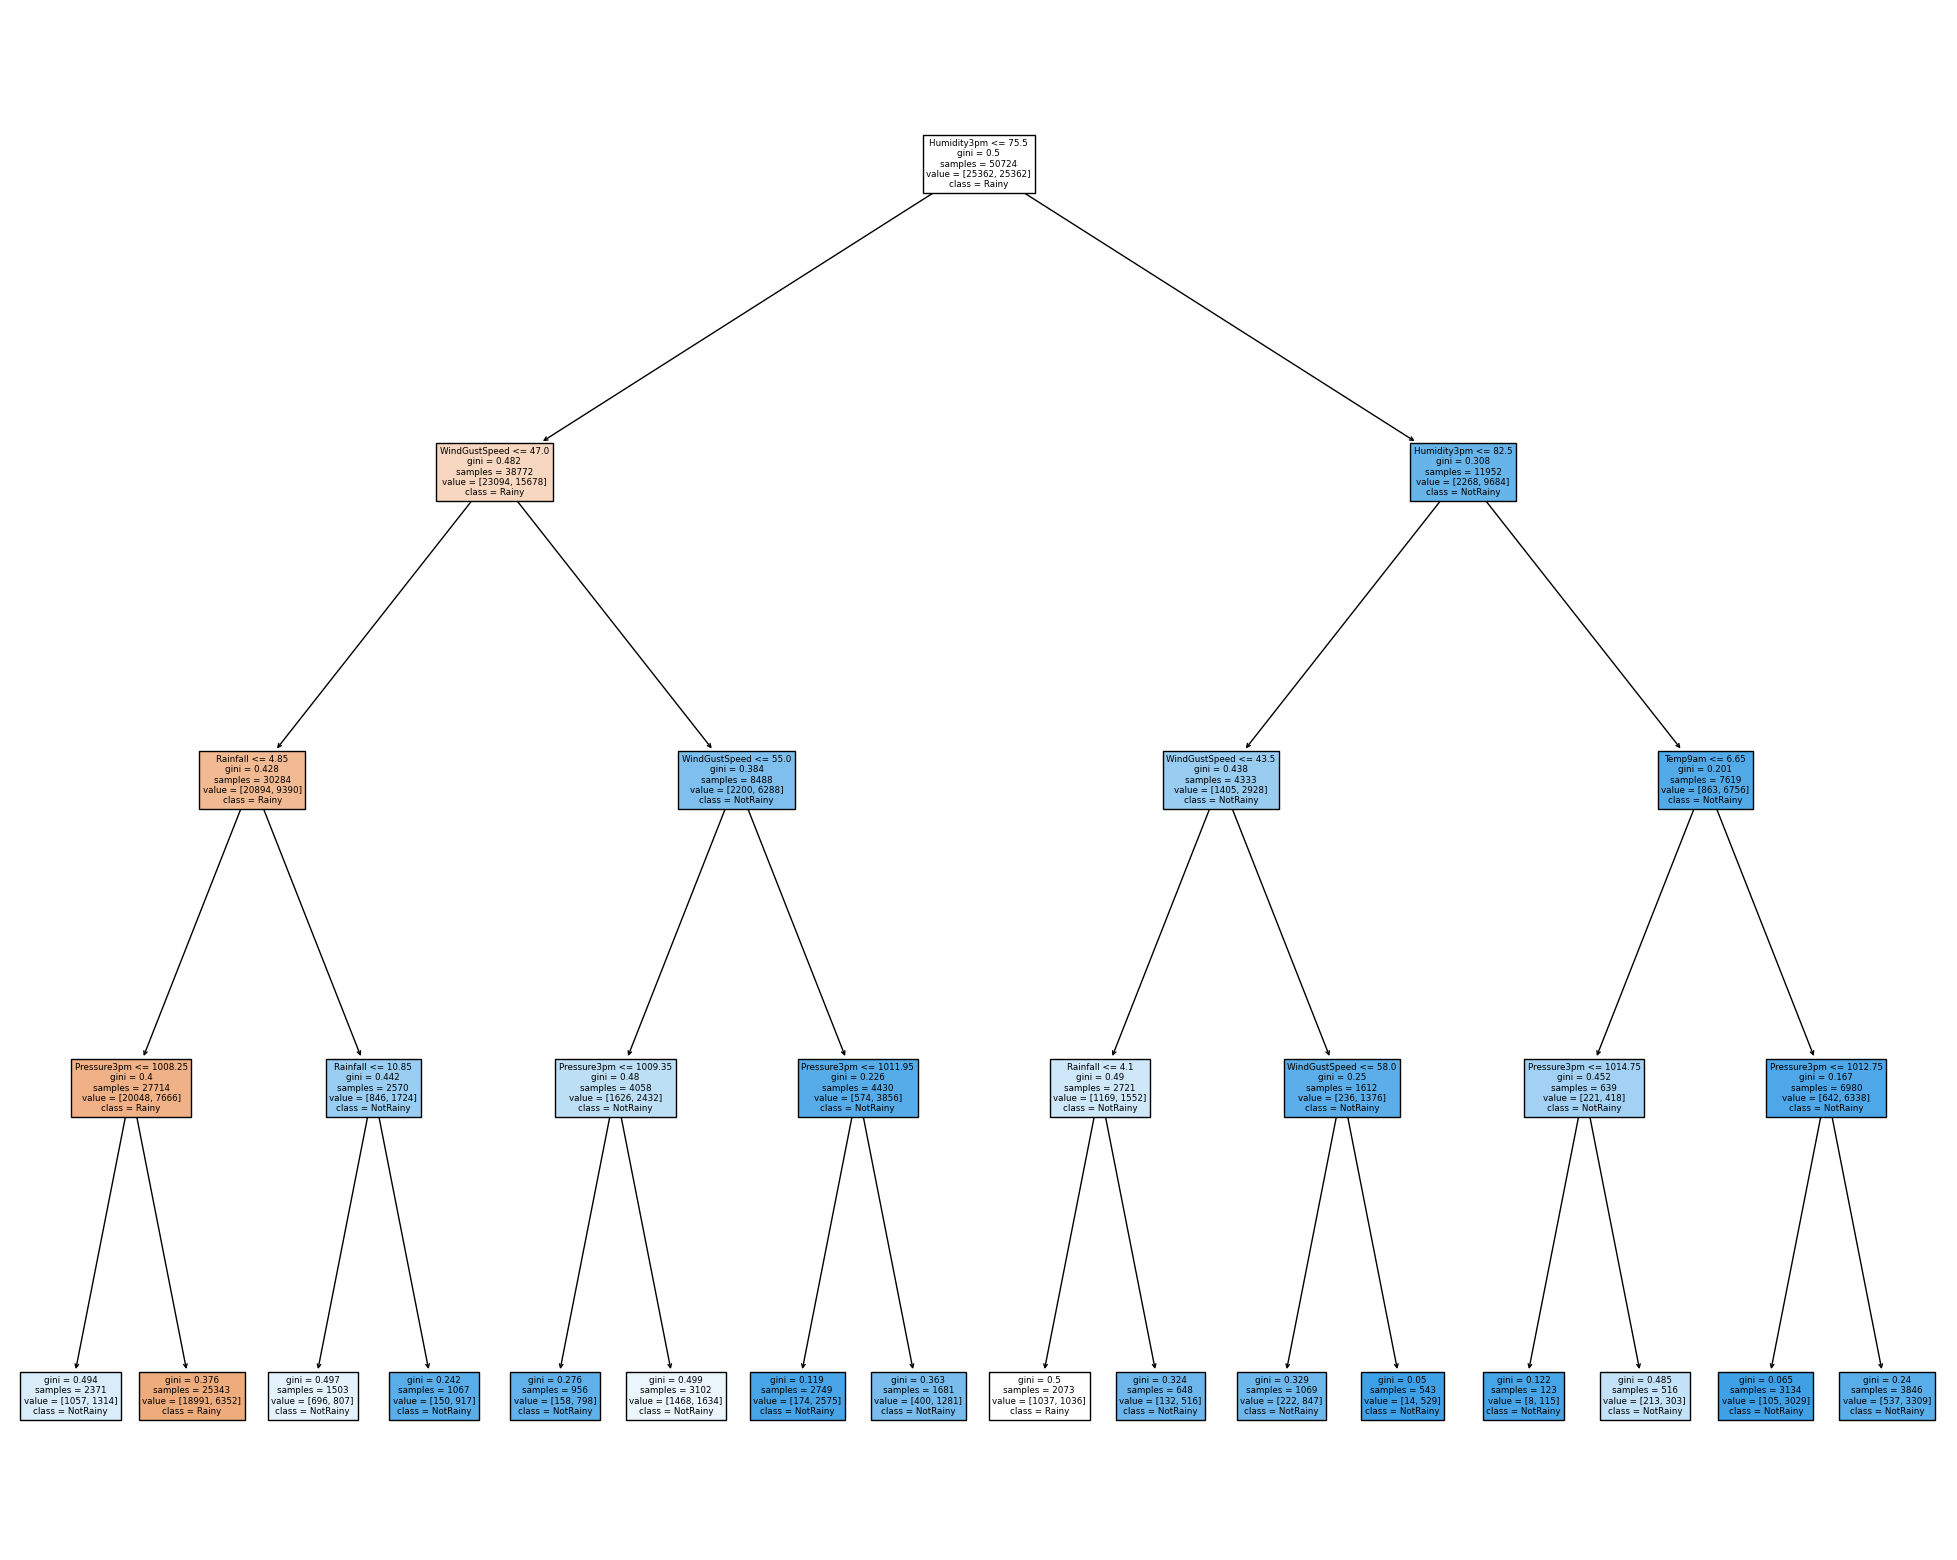

In [20]:
T(clf, 'cl')

In [21]:
y_pred = clf.predict(X_test_cl)

In [22]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.69      0.77     21924
           1       0.40      0.71      0.51      6515

    accuracy                           0.69     28439
   macro avg       0.64      0.70      0.64     28439
weighted avg       0.78      0.69      0.71     28439



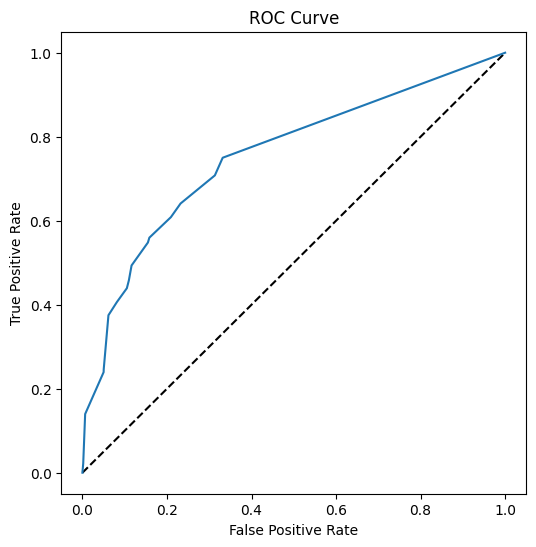

AUC: 0.7540776530323199


In [23]:
show_roc(X_test_cl, y_test_cl, clf)

## DecisionTreeRegressor

In [24]:
parameters_r = {
    'max_depth': np.arange(3, 5, 1), 'min_samples_split': np.arange(2, 10, 1), 
    'min_samples_leaf': np.arange(1, 5, 1), 'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}
reg = GridSearchCV(DecisionTreeRegressor(), parameters_r).fit(X_train_reg, y_train_reg)
print(reg.best_params_)
reg = reg.best_estimator_

{'criterion': 'poisson', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


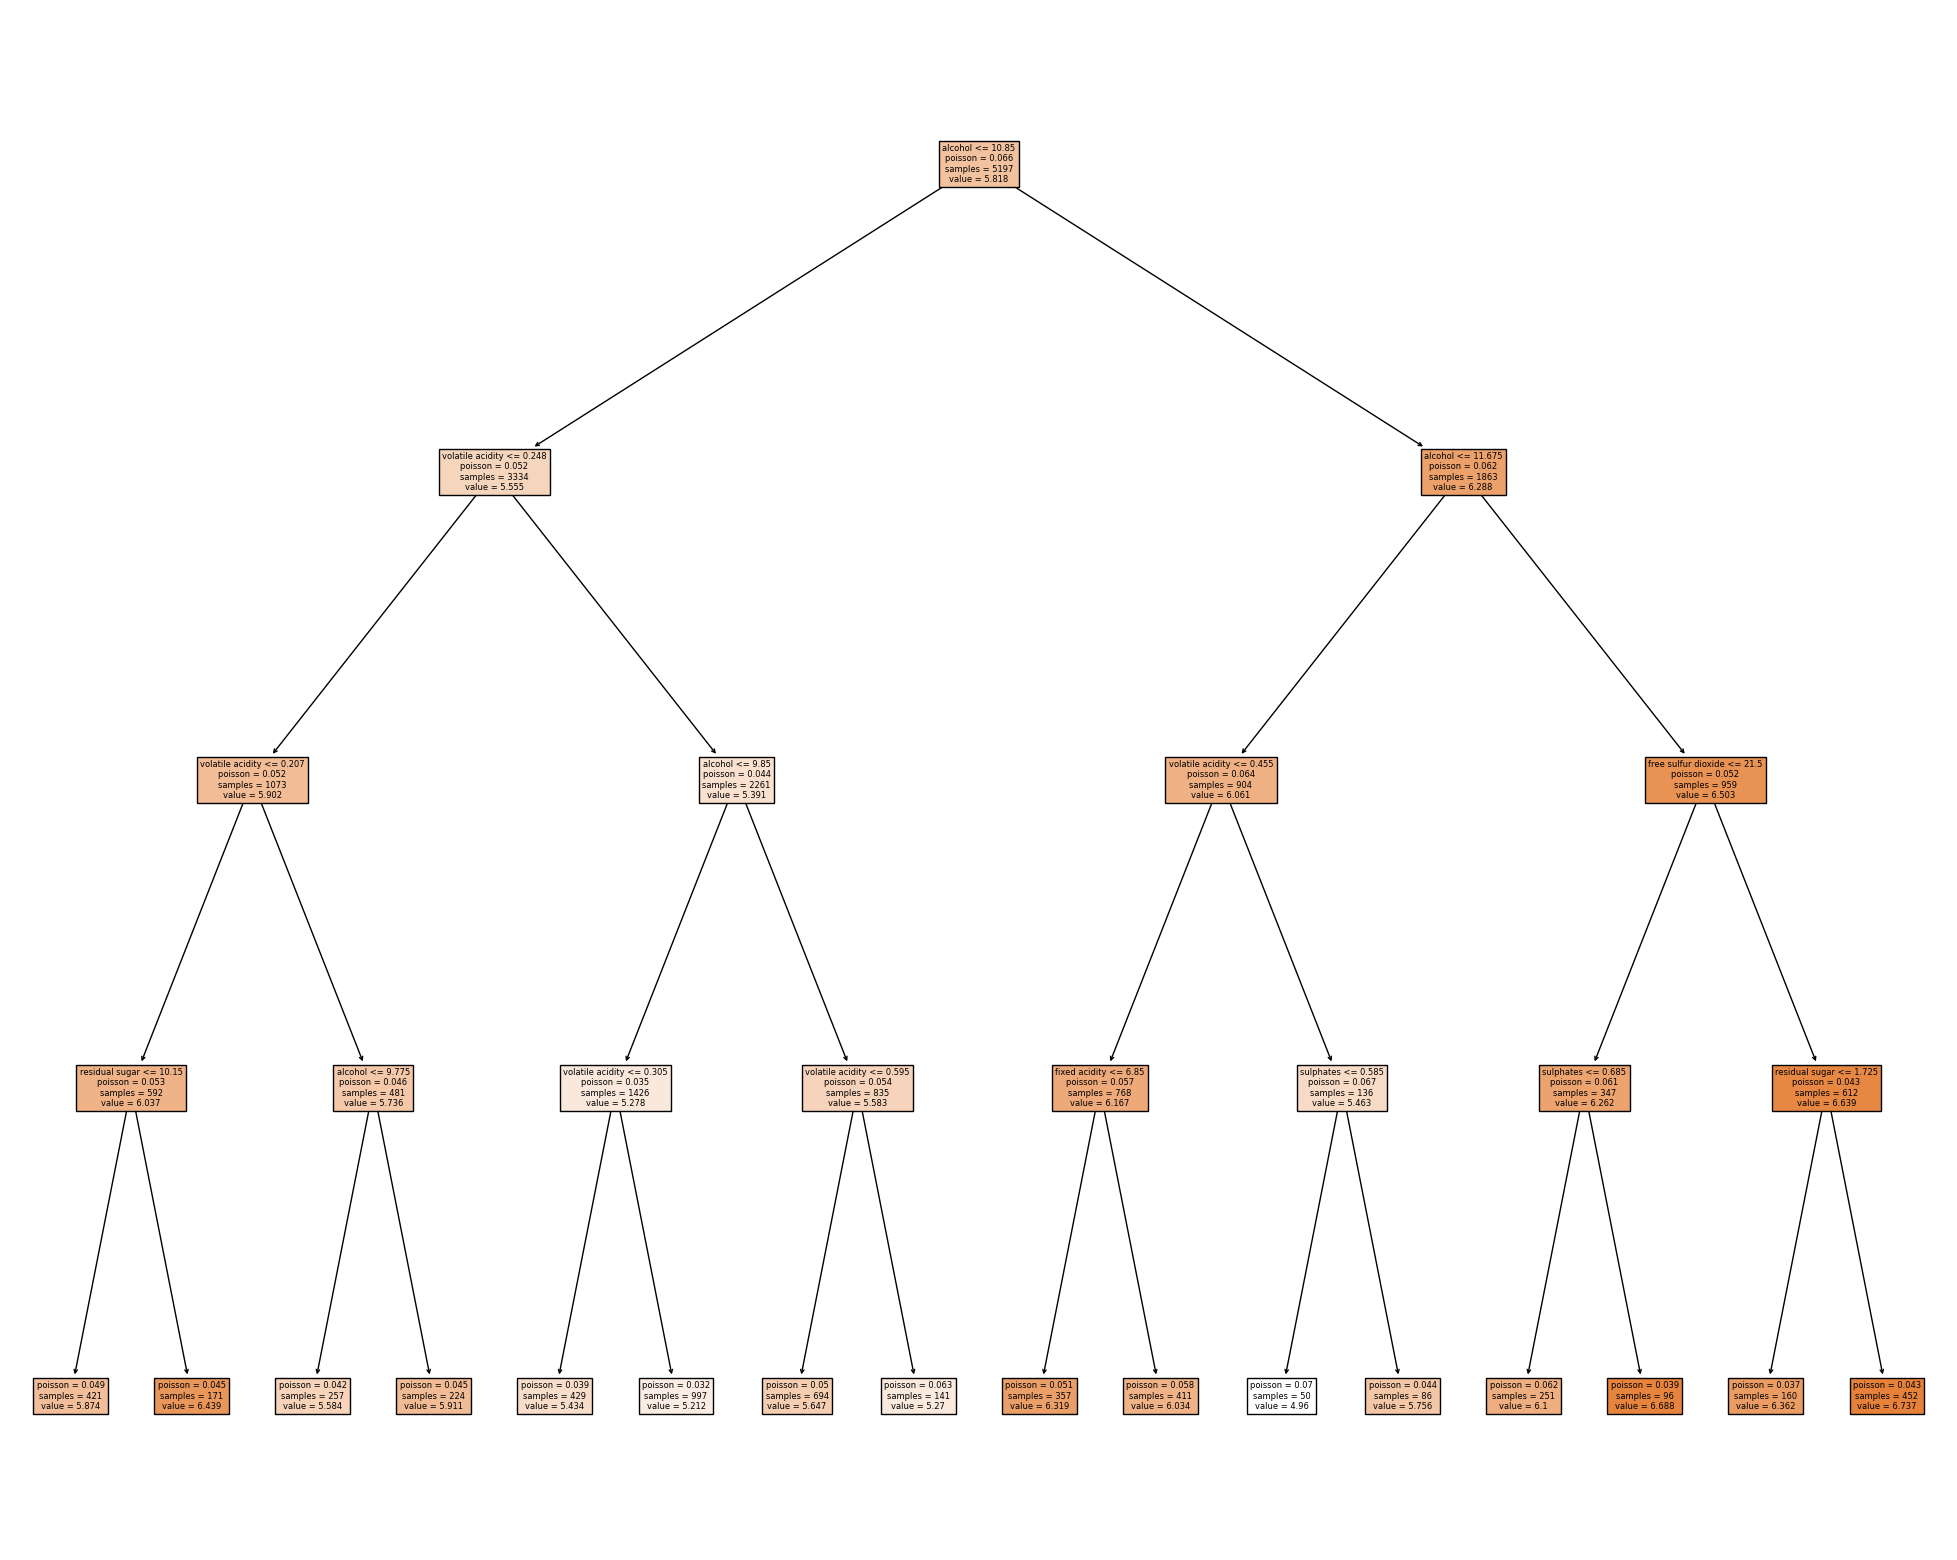

In [25]:
T(reg, 'rg')

In [26]:
y_pred = reg.predict(X_test_reg)

In [27]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.5714382424059674,
 'MSE': 0.5421338833744737,
 'MAPE': 0.10200685043700954,
 'R2': 0.2899139618276254}

## Ансамбли

### BaggingClassifier

In [28]:
bclf = BaggingClassifier(estimator=DecisionTreeClassifier(criterion = 'gini', max_depth = 6), n_estimators=3, random_state=0).fit(X_train_cl, y_train_cl)

In [29]:
y_pred = bclf.predict(X_test_cl)

In [30]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.75      0.81     21924
           1       0.45      0.68      0.54      6515

    accuracy                           0.73     28439
   macro avg       0.67      0.72      0.68     28439
weighted avg       0.79      0.73      0.75     28439



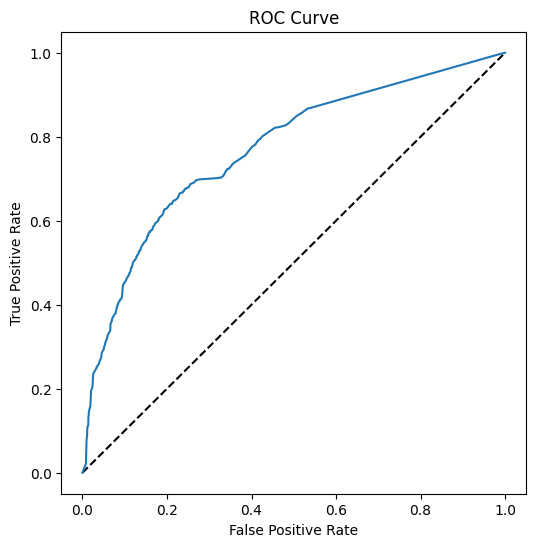

AUC: 0.7686594575021812


In [31]:
show_roc(X_test_cl, y_test_cl, bclf)

## BaggingRegressor

In [32]:
breg = BaggingRegressor(estimator=DecisionTreeRegressor(criterion = 'poisson', max_depth = 6, min_samples_leaf = 4), n_estimators=3, random_state=0)
breg.fit(X_train_reg, y_train_reg)

BaggingRegressor(estimator=DecisionTreeRegressor(criterion='poisson',
                                                 max_depth=6,
                                                 min_samples_leaf=4),
                 n_estimators=3, random_state=0)

In [33]:
y_pred = breg.predict(X_test_reg)

In [34]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.5446766333893056,
 'MSE': 0.5063235064574344,
 'MAPE': 0.09757014093146509,
 'R2': 0.33681833259338956}

## GradientBoostingClassifier

In [50]:
parameters_gb = {'loss': ['log_loss', 'exponential'], 'learning_rate': np.arange(0, 1, 0.1)}

In [51]:
gbclf = GridSearchCV(GradientBoostingClassifier(), parameters_gb).fit(X_train_cl, y_train_cl)

In [52]:
y_pred = gbclf.predict(X_test_cl)

In [53]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.62      0.73     21924
           1       0.37      0.75      0.49      6515

    accuracy                           0.65     28439
   macro avg       0.63      0.68      0.61     28439
weighted avg       0.77      0.65      0.68     28439



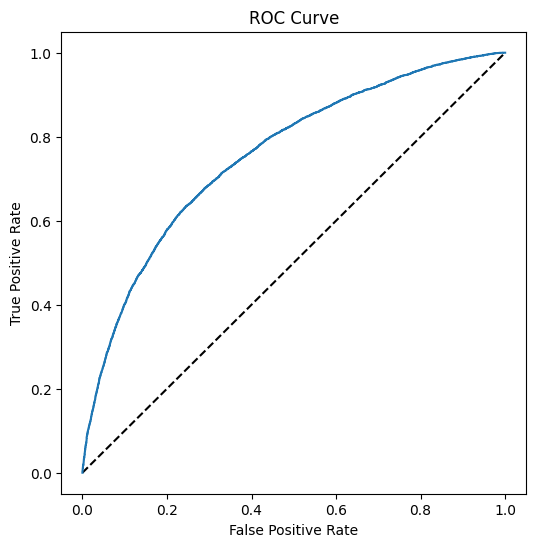

AUC: 0.7566508413982413


In [54]:
show_roc(X_test_cl, y_test_cl, gbclf)

## GradientBoostingRegressor

In [55]:
parameters_gb = {'n_estimators': np.arange(10, 150, 10)}

In [56]:
gbreg = GridSearchCV(GradientBoostingRegressor(), parameters_gb).fit(X_train_reg, y_train_reg)

In [57]:
y_pred = gbreg.predict(X_test_reg)

In [58]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.5160833511825504,
 'MSE': 0.44220852276791633,
 'MAPE': 0.09206979071681293,
 'R2': 0.42079602915829684}

## StackingClassifier

In [121]:
estimators = [
     ('lr', make_pipeline(StandardScaler(), LogisticRegression())),
     ('dt', DecisionTreeClassifier(criterion = 'gini', max_depth = 6)),
     ('knn', KNeighborsClassifier(n_neighbors = 13, weights = 'distance'))
]

sclf = StackingClassifier(estimators=estimators)

In [122]:
sclf.fit(X_train_cl, y_train_cl)
y_pred = sclf.predict(X_test_cl)

In [123]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.74      0.81     21924
           1       0.45      0.72      0.56      6515

    accuracy                           0.74     28439
   macro avg       0.68      0.73      0.68     28439
weighted avg       0.80      0.74      0.75     28439



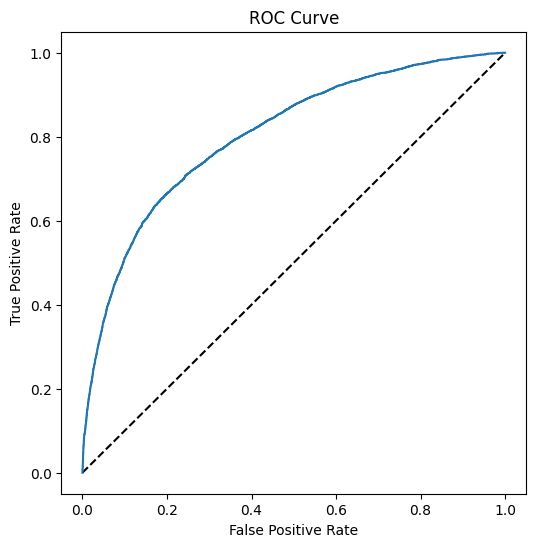

AUC: 0.8041310573623273


In [124]:
show_roc(X_test_cl, y_test_cl, sclf)

## StackingRegressor

In [118]:
estimators = [
     ('elnet', make_pipeline(StandardScaler(), ElasticNet(alpha=0.01, l1_ratio=0.01))),
     ('dtr', DecisionTreeRegressor(criterion = 'poisson', max_depth = 6, min_samples_leaf = 4)),
]

sreg = StackingRegressor(estimators=estimators)

In [119]:
sreg.fit(X_train_reg, y_train_reg)
y_pred = sreg.predict(X_test_reg)

In [120]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.5449197908497002,
 'MSE': 0.49270286717447404,
 'MAPE': 0.09706828124210838,
 'R2': 0.35465862275494664}

## Выбор наилучшей модели

### Classifier

Лучшим по всем метрикам (для второго класса) оказался stacking classifier с комбинацией из логистической регрессии, дерева классификации и kNN.

### Regressor

Лучшим оказался gradient boosting regressor, оторвавшийся по метрике R^2 далеко вперед относительно других ансамблей.

## Catboost

In [10]:
train_dataset_cl = cb.Pool(X_train_cl, y_train_cl)

In [11]:
train_dataset_reg = cb.Pool(X_train_reg, y_train_reg)

### Classifier

In [ ]:
cbclf = cb.CatBoostClassifier(loss_function='Logloss',
                              eval_metric='Accuracy')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}

cbclf.grid_search(grid, train_dataset_cl)

In [25]:
y_pred = cbclf.predict(X_test_cl)
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.92      0.64      0.75     22065
           1       0.39      0.80      0.52      6374

    accuracy                           0.67     28439
   macro avg       0.65      0.72      0.64     28439
weighted avg       0.80      0.67      0.70     28439



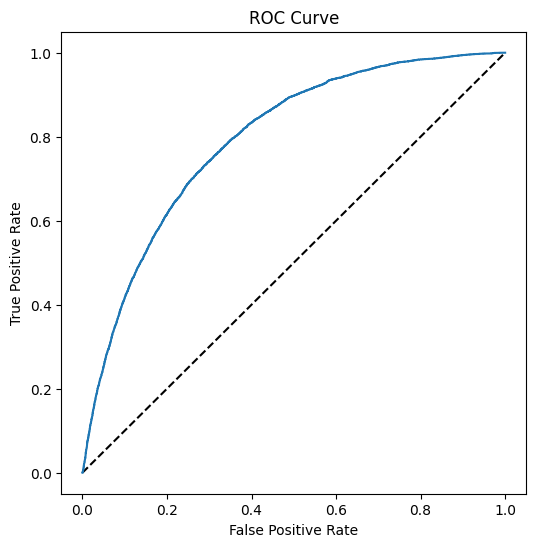

AUC: 0.7935681019459934


In [26]:
show_roc(X_test_cl, y_test_cl, cbclf)

### Regressor

In [ ]:
cbreg = cb.CatBoostRegressor(loss_function='RMSE')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}


cbreg.grid_search(grid, train_dataset_reg)

In [36]:
y_pred = cbreg.predict(X_test_reg)
show_reg(y_test_reg, y_pred)

{'MAE': 0.3411794799251605,
 'MSE': 0.20515217193344196,
 'MAPE': 0.05990492134607237,
 'R2': 0.7312920342039357}

## XGBoost

### Classifier

In [31]:
params = {'max_depth': np.arange(3, 5, 1), 'learning_rate': np.arange(0, 1, 0.1), 'n_estimators': np.arange(50, 150, 25)}

In [49]:
xgclf = GridSearchCV(xgb.XGBClassifier(), params).fit(X_train_cl, y_train_cl)

In [50]:
y_pred = xgclf.predict(X_test_cl)

In [51]:
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.60      0.72     21991
           1       0.36      0.76      0.49      6448

    accuracy                           0.64     28439
   macro avg       0.63      0.68      0.61     28439
weighted avg       0.78      0.64      0.67     28439



### Regressor

In [32]:
xgreg = GridSearchCV(xgb.XGBRegressor(), params).fit(X_train_reg, y_train_reg)

In [33]:
y_pred = xgreg.predict(X_test_reg)

In [34]:
show_reg(y_test_reg, y_pred)

{'MAE': 0.5162032578541682,
 'MSE': 0.44555534718021916,
 'MAPE': 0.09184784388833285,
 'R2': 0.4164123642366392}

## LightGBM

### Classifier

In [ ]:
lclf = GridSearchCV(lgbm.LGBMClassifier(), params).fit(X_train_cl, y_train_cl)

In [37]:
y_pred = lclf.predict(X_test_cl)
show_class(y_test_cl, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.59      0.71     22065
           1       0.35      0.75      0.48      6374

    accuracy                           0.63     28439
   macro avg       0.62      0.67      0.59     28439
weighted avg       0.77      0.63      0.66     28439



### Regressor

In [ ]:
lreg = GridSearchCV(lgbm.LGBMRegressor(), params).fit(X_train_reg, y_train_reg)

In [39]:
y_pred = lreg.predict(X_test_reg)
show_reg(y_test_reg, y_pred)

{'MAE': 0.5198241460034306,
 'MSE': 0.4536683406375045,
 'MAPE': 0.09279772866957028,
 'R2': 0.40578597920801174}

## Выбор наилучшей модели

### Classifier

Лучшим оказался catboost, поскольку второй класс (означает, что на следующий день пойдет дождь) предсказывается с наибольшей точностью.

### Regressor

Лучшим оказался catboost, поскольку R^2 и MAPE метрики замтено лучше, чем у XGBoost и LightGBM.